https://www.kaggle.com/datasets/nathanaeltenno/protel-dataset

In [7]:
import torch
import torchvision

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

print(torch.__version__)
print(torchvision.__version__)

2.3.0.dev20240120+cu121
0.18.0.dev20240120+cu121


In [8]:
import os
import random
import matplotlib.pyplot as plt
import glob
import numpy as np
import json

from sklearn.model_selection import train_test_split
from pathlib import Path

In [9]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [4]:
### import custom scripts
from scripts import engine_classification, custom_dataset, create_data_splits

In [10]:
# root path
root_path = Path(os.getcwd())
print(root_path)
# directories
train_dir = root_path / "dataset_subset" / "train"
val_dir = root_path / "dataset_subset" / "val"
test_dir = root_path / "dataset_subset" / "test"

/mnt/DiscoD/00_Learning/00_ArtificialIntelligence/AI_Aplications/10_Fruits_protel


In [11]:
classes_ = os.listdir(root_path / "dataset")
len(classes_)

30

In [12]:
# Filter for FRESH category
classes = list(filter(lambda x: "Fresh" in x, classes_)) 
len(classes)

15

In [16]:
# save class file
with open("classes", "w") as fj:
    json.dump(classes, fj)

### Create splits dir

In [8]:
# create
train_ratio=0.6
val_ratio=0.2
test_ratio=0.1

#create_data_splits.create_data_splits(root_path / "dataset", classes, train_dir, test_dir, val_dir, train_ratio, test_ratio, val_ratio)

### Setup model

In [9]:
# Initialize model with the best available weights
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [10]:
# Freeze all of the base layers in model
for param in model.parameters():
  param.requires_grad = False

In [11]:
# Set the manual seeds, we're creating a new layer with random weights (torch.nn.Linear). 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Update the classifier head to our class
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(classes))).to(device) # how many classes do we have?

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=15, bias=True)
)

In [12]:
transform = weights.transforms()
transform

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Setup Dataset / DataLoaders

In [13]:
# Create training and testing Dataset, and get a list of class names
train_data = custom_dataset.CustomDataset_classification(targ_dir=train_dir, transform=transform)
val_data = custom_dataset.CustomDataset_classification(targ_dir=val_dir, transform=transform)
test_data = custom_dataset.CustomDataset_classification(targ_dir=test_dir, transform=transform)

class_names = train_data.classes
len(class_names)

15

In [14]:
# Turn data custom Datasets into DataLoaders
BATCH_SIZE = 24

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=True) 
test_dataloader  = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False) 
val_dataloader  = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc18b0d5eb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc18b0d5df0>)

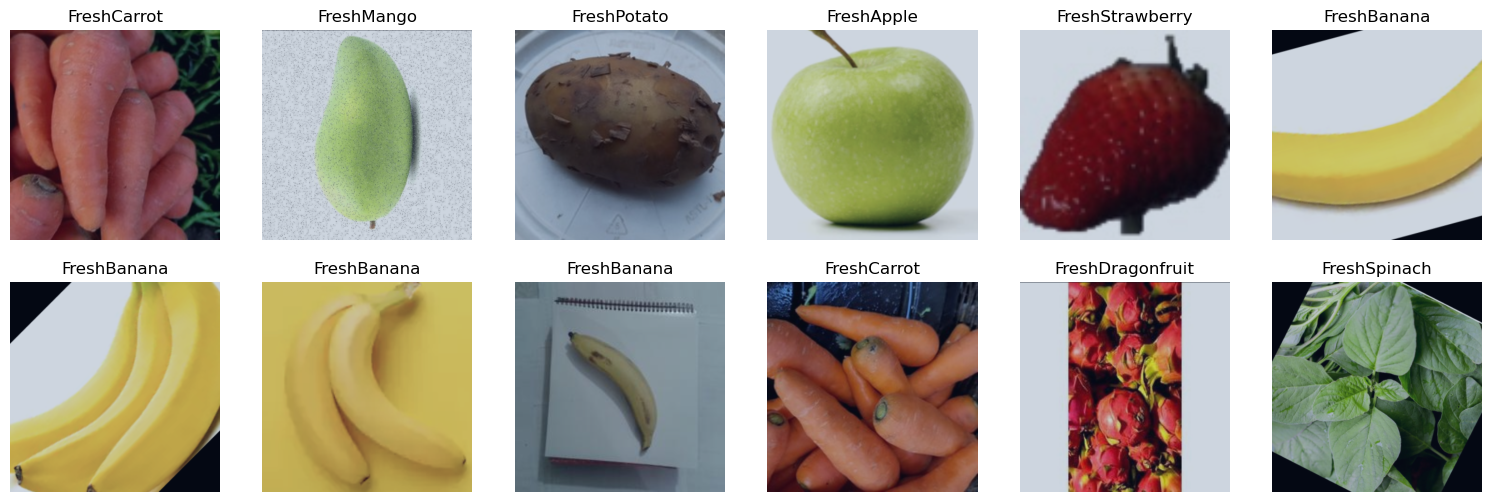

In [15]:
# visualize a batch of train data loader
images, labels = next(iter(train_dataloader))
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(19, 6))
rows, cols = 2, 6
for i in range(0, rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image_ = np.transpose(images[i], (1, 2, 0)) 
    image_ = image_*[0.18]+[0.4] # unnormalize 
    plt.imshow(image_)
    plt.title(class_names[labels[i].item()])
    plt.axis(False);

### Train model

In [16]:
class EarlyStopping:
    def __init__(self, tolerance=3, patience=5, min_delta=0.001):
        self.tolerance = tolerance
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_metric = None

    def __call__(self, validation_loss, validation_metric):
        # Check for improvement in validation metric
        if (self.best_metric is None or
                validation_metric - self.best_metric > self.min_delta):
            self.best_metric = validation_metric
            self.counter = 0
        else:
            self.counter += 1

        # Early stopping based on patience and tolerance
        if self.counter >= self.tolerance and self.patience > 0:
            self.early_stop = True

In [17]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, 
                                                       threshold=0.0001, threshold_mode='rel')
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
early_stopping = EarlyStopping(tolerance=3, patience=5, min_delta=0.001)  # Adjust parameters

In [18]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 20
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine_classification.run_model(model=model,
                       train_dataloader=train_dataloader,
                       validation_dataloader=val_dataloader, 
                       optimizer=optimizer,
                       scheduler=scheduler,
                       early_stopping=early_stopping,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device)

# End the timer
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Training Step: 0it [00:00, ?it/s]

/usr/lib64/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Step: 0it [00:00, ?it/s]

Epoch: 1 | lr: 0.001 | train_loss: 0.6026 | train_acc: 0.9013 | validation_loss: 0.1750 | validation_acc: 0.9759
model saved at epoch: 1


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 2 | lr: 0.001 | train_loss: 0.1586 | train_acc: 0.9731 | validation_loss: 0.1072 | validation_acc: 0.9801
model saved at epoch: 2


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 3 | lr: 0.001 | train_loss: 0.1071 | train_acc: 0.9798 | validation_loss: 0.0751 | validation_acc: 0.9855
model saved at epoch: 3


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 4 | lr: 0.001 | train_loss: 0.0839 | train_acc: 0.9818 | validation_loss: 0.0697 | validation_acc: 0.9866
model saved at epoch: 4


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 5 | lr: 0.001 | train_loss: 0.0672 | train_acc: 0.9858 | validation_loss: 0.0594 | validation_acc: 0.9870
model saved at epoch: 5


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 6 | lr: 0.001 | train_loss: 0.0656 | train_acc: 0.9837 | validation_loss: 0.0552 | validation_acc: 0.9881
model saved at epoch: 6


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 7 | lr: 0.001 | train_loss: 0.0574 | train_acc: 0.9864 | validation_loss: 0.0517 | validation_acc: 0.9893
model saved at epoch: 7


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 8 | lr: 0.001 | train_loss: 0.0487 | train_acc: 0.9881 | validation_loss: 0.0477 | validation_acc: 0.9893
model saved at epoch: 8


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 9 | lr: 0.001 | train_loss: 0.0441 | train_acc: 0.9897 | validation_loss: 0.0471 | validation_acc: 0.9874
model saved at epoch: 9


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 10 | lr: 0.001 | train_loss: 0.0445 | train_acc: 0.9869 | validation_loss: 0.0430 | validation_acc: 0.9893
model saved at epoch: 10
early stopping at epoch: 9
[INFO] Total training time: 6164.231 seconds


In [19]:
def plot_loss_curves(results):   
    loss = results["train_loss"]
    val_loss = results["validation_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["validation_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

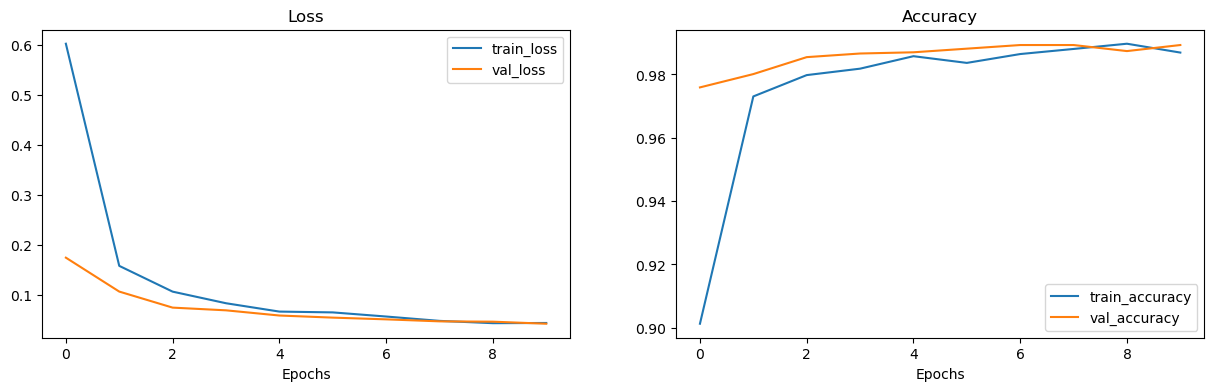

In [20]:
# Plot the loss curves of our model
plot_loss_curves(results)

# Inference / Load saved model

In [57]:
import torch
import torchvision
import json
import matplotlib.pyplot as plt
import os
import random

from PIL import Image
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [39]:
# load model using full model saved
# load weights for getting transform
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
transform = weights.transforms()
model_load = torch.load('models/model_full_EfficientNet_202402251825') # full model, without the need to recreate the architecture and load the state dictionary separately

In [40]:
# load classes file
with open("classes", "r") as fj:
    classes = json.load(fj)

In [49]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names,
    transform,
    device):
       
    image = Image.open(image_path) # Load in image 
    
    image = transform(image).unsqueeze(0).to(device) # Transform the image, add batch dimension and put image on target device
    
    model.to(device) # model on the target device     
    model.eval() # Turn on model evaluation mode and inference mode
    
    pred_dict = {}
    
    with torch.no_grad():     
        pred_logit = model(image) # perform inference on target sample 
        pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
        pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
        pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

        # put in the dictionary
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_class"] = pred_class
        
    # Plot the image
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy()*[0.18]+[0.4]) # unnormalize  
    
    if class_names:
        title = f"Pred: {class_names[pred_label.cpu()]} | Prob: {pred_prob.max().cpu():.3f}"
    else:
        title = f"Pred: {pred_label} | Prob: {pred_prob.max().cpu():.3f}"
        
    plt.title(title)
    plt.axis(False)

    return pred_dict

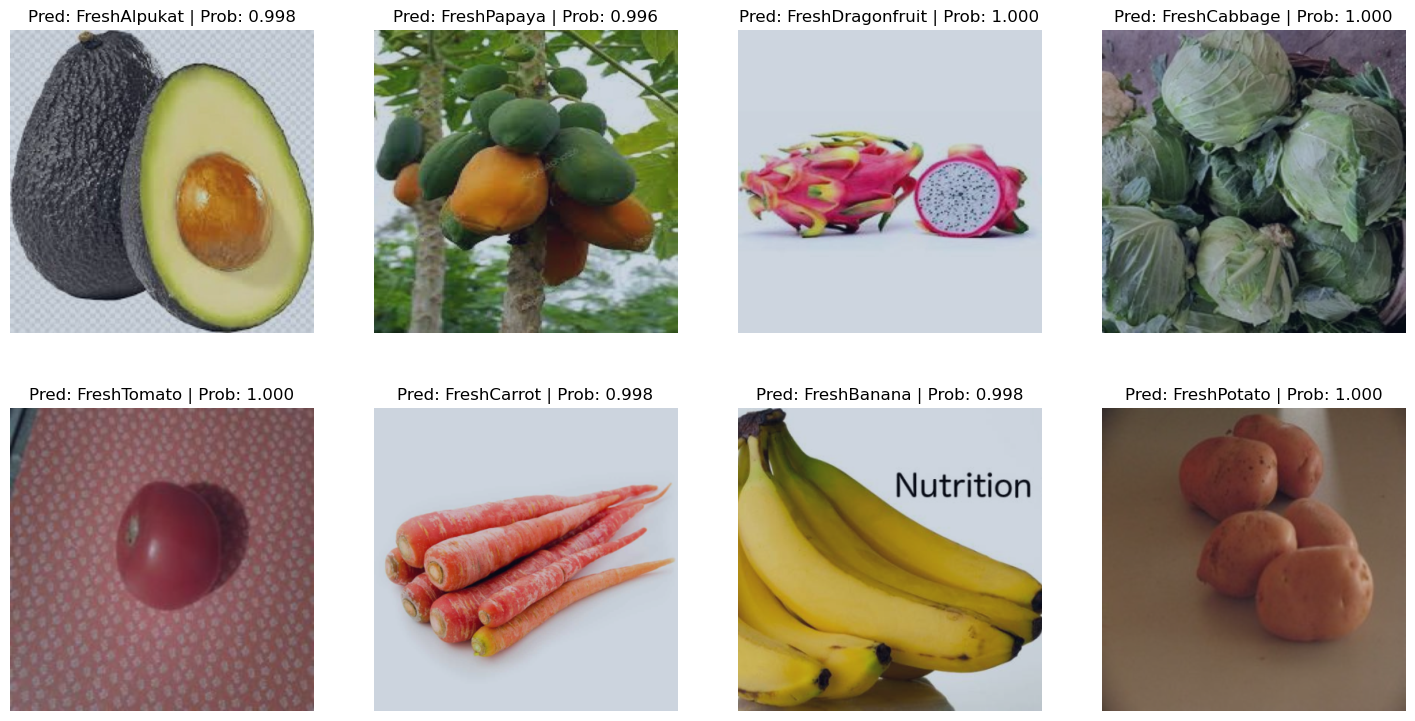

In [77]:
root_path = Path(os.getcwd())
# Get a list of all test image filepaths
test_dir = root_path / "dataset_subset" / "test"
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
img_paths = random.sample(test_data_paths, k=8)

fig = plt.figure(figsize=(18, 9))
rows, cols = 2, 4
for i in range(0, rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    img = img_paths[i]
    pred_dict = pred_and_plot_image(model_load, img, classes, transform, device)